In [169]:
from pyquery import PyQuery as pq
import pandas as pd
import requests
import seaborn as sns
from tqdm import tqdm_notebook
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import numpy as np

In [4]:
def extract_projects(page):
    document = pq("https://junction2017.devpost.com/submissions?page={}".format(page))
    return document(".block-wrapper-link.fade.link-to-software")

In [17]:
projects = []
for i in tqdm_notebook(range(0, 15)):
    links = extract_projects(i)
    for link in links:
        projects.append(link.get("href"))

In [19]:
def extract_project(link):
    document = pq(link)
    return {
        "name": document("#app-title").text(),
        "description": document("#software-header p.large").text(),
        "info": document("#app-details-left").text(),
        "participants": document("#app-team a.user-profile-link").text(),
        "technologies": document("#built-with li").text(),
    }

In [23]:
project_info = []
for project in tqdm_notebook(projects):
    project_info.append(extract_project(project))

In [24]:
project_info_df = pd.DataFrame(project_info)
project_info_df.to_csv("some_file.csv")

In [27]:
project_info_df["participants_parsed"] = project_info_df["participants"].apply(lambda x: x.split("  "))

In [29]:
project_info_df["technologies_parsed"] = project_info_df["technologies"].apply(lambda x: x.split(" "))

In [31]:
langs = []
for i in project_info_df["technologies_parsed"]:
    langs += i

In [35]:
count_langs = {}
for l in langs:
    count_langs[l] = count_langs.get(l, 0) + 1
del count_langs['']

In [82]:
langs_df = pd.DataFrame({"lang": l, "count": c }for l, c in count_langs.items())

In [83]:
langs_df.sort_values("count", ascending=[0]).head(10)

,count,lang
341,121,python
131,97,javascript
127,64,node.js
231,48,react
8,41,java
360,32,html5
135,29,unity
311,27,android
262,26,flask
219,26,css


In [87]:
popular_langs = langs_df.sort_values("count", ascending=[0]).head(21).set_index("lang")

In [88]:
popular_langs.loc["other"] = langs_df.sort_values("count")[:-21]["count"].sum()

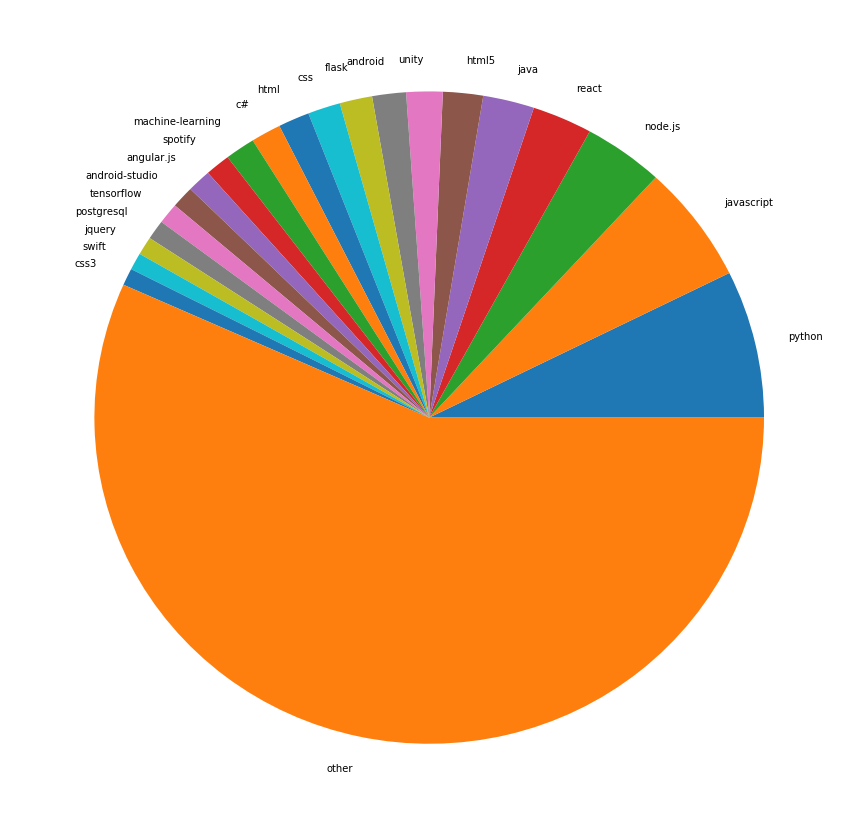

In [133]:
plt.figure(figsize=(15, 15))
plt.pie(popular_langs["count"], labels=popular_langs.index)
plt.show()

In [103]:
project_info_df["description_parsed"] = project_info_df["description"].apply(lambda x: [w for w in re.sub(r'[^\w]', ' ', x.lower()).split(" ") if len(w) > 3])

In [120]:
words = []
for i in project_info_df["description_parsed"]:
    words += i

In [125]:
swords = set(stopwords.words('english'))

In [126]:
cleaned_words = []
for word in words:
    if word not in swords:
        cleaned_words.append(word)

In [128]:
count_words = {}
for l in cleaned_words:
    count_words[l] = count_words.get(l, 0) + 1

In [129]:
words_df = pd.DataFrame({"word": w, "count": c }for w, c in count_words.items())

In [135]:
words_df.sort_values("count", ascending=0).head(20)

,count,word
737,28,based
258,25,people
971,22,data
550,19,movie
412,17,smart
313,15,using
47,15,game
112,14,time
231,14,management
567,14,make


# Words and technologies correlation

In [203]:
popular_words = words_df.sort_values("count", ascending=0).head(50)["word"]
popular_technologies = langs_df.sort_values("count", ascending=[0]).head(20)["lang"]

In [204]:
heatmap = []
for word in tqdm_notebook(popular_technologies):
    heatmap.append([])
    for technology in popular_technologies:
        attached_projects = project_info_df[project_info_df["technologies_parsed"].apply(lambda x: technology in x) & project_info_df["technologies_parsed"].apply(lambda x: word in x)]
        heatmap[-1].append(attached_projects.shape[0])

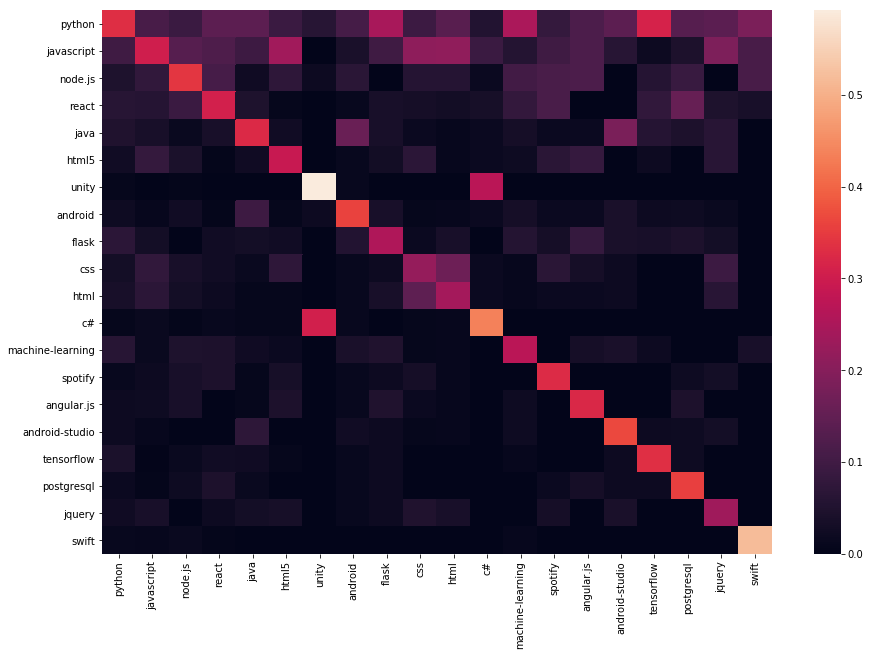

In [211]:
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap / np.sum(heatmap, axis=0), xticklabels=popular_technologies, yticklabels=popular_technologies)

In [191]:
heatmap = []
for word in tqdm_notebook(popular_words):
    heatmap.append([])
    for technology in popular_technologies:
        attached_projects = project_info_df[project_info_df["technologies_parsed"].apply(lambda x: technology in x) & project_info_df["description_parsed"].apply(lambda x: word in x)]
        heatmap[-1].append(attached_projects.shape[0])

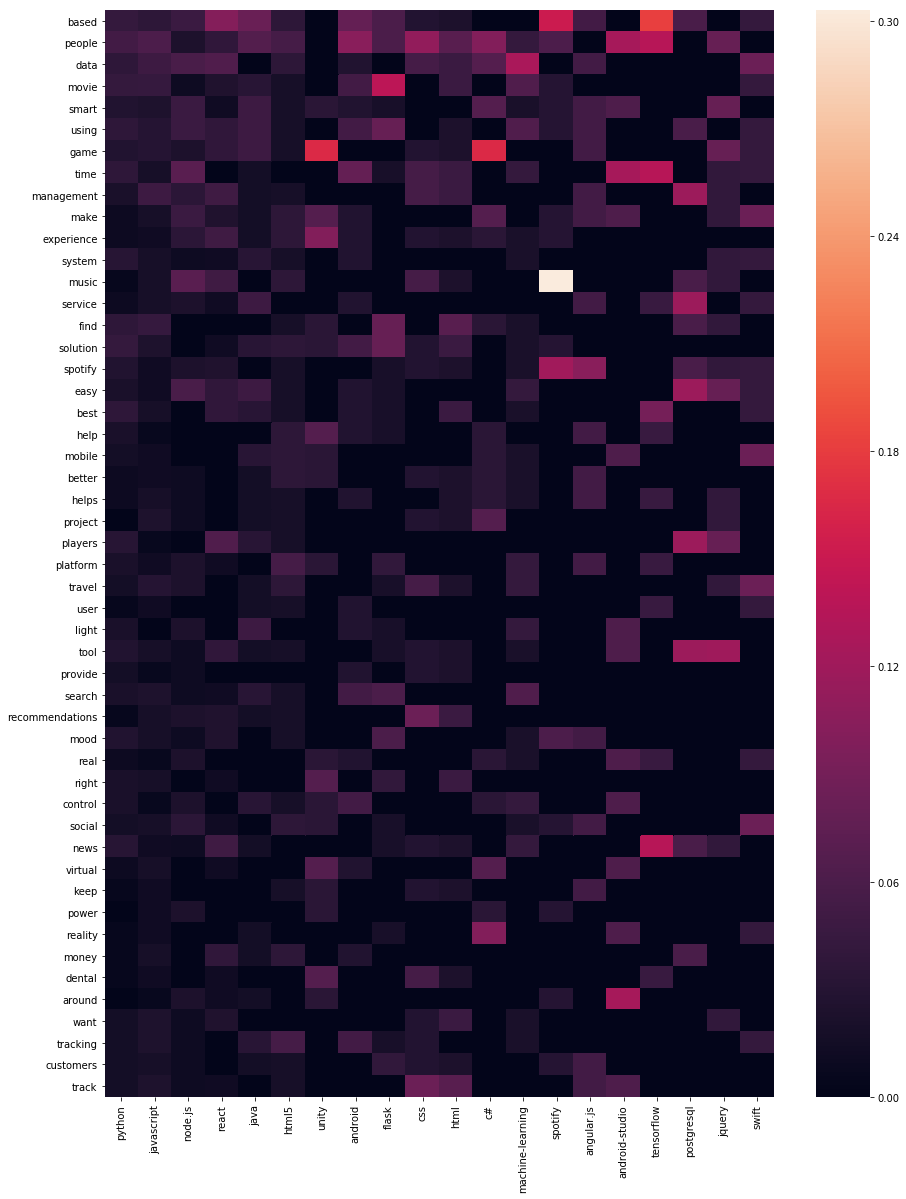

In [201]:
plt.figure(figsize=(15, 20))
sns.heatmap(heatmap / np.sum(heatmap, axis=0), xticklabels=popular_technologies, yticklabels=popular_words)

In [212]:
# Active participants

In [213]:
participants = []
for i in project_info_df["participants_parsed"]:
    participants += i

In [214]:
count_people = {}
for l in participants:
    count_people[l] = count_people.get(l, 0) + 1

In [215]:
people_df = pd.DataFrame({"name": l, "count": c }for l, c in count_people.items())

In [217]:
people_df.sort_values("count", ascending=0).head(10)

,count,name
543,3,CaritaFurstenborg
796,3,ahmad2520
567,3,Olli Peura
617,3,Mark Bogdanov
957,3,VissKate
715,3,Dan Samoylov
64,3,Mikhail Kolchanov
403,2,Nikita Atrashkevich
348,2,Kirill Makarov
355,2,ShuangQ
